In [1]:
import r3.adapters as adapters
import r3.schema as schema


X_columns = [
    schema.IVTReactionSchema.pH.value,
    schema.IVTReactionSchema.TIME_min.value,
]
y_columns = [schema.IVTReactionSchema.RNA_g_L.value]
experimental_conditions, response = adapters.DataPipelineAdapter(
    "kate_ph_repeat", verbose=False
).get(
    X_columns=X_columns,
    y_columns=y_columns,
    paths_to_merge=[
        ["charlie_ph", "Sheet1"],
        ["ricardo_ph", "CSP HEPES"],
        ["ricardo_ph", "eGFP HEPES"],
        ["ricardo_ph", "eGFP TRIS"],
    ],
)
experimental_data = experimental_conditions.copy()
experimental_data[y_columns[0]] = response[y_columns[0]]
experimental_data

,pH,Reaction Time [min],RNA [g/L]
0,6.57,0.0,0.000000
1,6.52,4.0,1.322399
2,6.49,8.0,2.844903
3,6.41,13.0,5.138938
4,6.37,18.0,7.869962
5,6.37,23.0,9.969641
6,6.29,31.0,11.647534
7,6.25,43.0,12.824160
8,6.20,60.0,13.605147
9,6.17,100.0,14.279864


<Axes: xlabel='pH', ylabel='RNA [g/L]'>

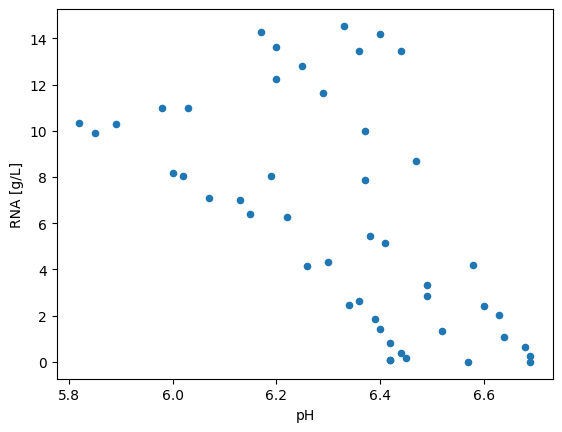

In [2]:
# visualise the data separate RNA and pH into different Axis
experimental_data.plot(
    x=schema.IVTReactionSchema.pH.value,
    y=schema.IVTReactionSchema.RNA_g_L.value,
    kind="scatter",
)

In [3]:
# fit a gaussian process model and an xgboost model
import xgboost
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (
    RBF,
    Matern,
    WhiteKernel,
    ConstantKernel as C,
)
from sklearn.base import BaseEstimator
import numpy as np
import json

# Train test split
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(
    experimental_conditions[X_columns].values,
    response[y_columns[0]].values,
    test_size=0.2,
    random_state=42,
)
gp = GaussianProcessRegressor(
    kernel=C(1.0, (1e-2, 1e2))
    * Matern(length_scale=1.0, length_scale_bounds=(1e-2, 1e2), nu=2.5)
    + WhiteKernel(noise_level=1.0, noise_level_bounds=(1e-2, 1e2)),
    n_restarts_optimizer=50,
    random_state=42,
)
gp.fit(X_train, y_train)
xgb_model = xgboost.XGBRegressor(
    n_estimators=50,
    learning_rate=0.1,
    max_depth=3,
    random_state=42,
)
xgb_model.fit(X_train, y_train)


# Evaluate the models using R squared, MAE and RMSE for train and test sets
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error


def evaluate_model(model: BaseEstimator, X_train, y_train, X_test, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)

    mae_train = mean_absolute_error(y_train, y_train_pred)
    mae_test = mean_absolute_error(y_test, y_test_pred)

    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

    return {
        "r2": {"train": r2_train, "test": r2_test},
        "mae": {"train": mae_train, "test": mae_test},
        "rmse": {"train": rmse_train, "test": rmse_test},
    }


gp_metrics = evaluate_model(gp, X_train, y_train, X_test, y_test)
xgb_metrics = evaluate_model(xgb_model, X_train, y_train, X_test, y_test)
print("Gaussian Process Metrics:", json.dumps(gp_metrics, indent=4))
print("XGBoost Metrics:", json.dumps(xgb_metrics, indent=4))

Gaussian Process Metrics: {
    "r2": {
        "train": 0.9729538640964586,
        "test": 0.7543687446926199
    },
    "mae": {
        "train": 0.5881294356487017,
        "test": 1.5713568518952221
    },
    "rmse": {
        "train": 0.7957864923546164,
        "test": 1.9764709578826825
    }
}
XGBoost Metrics: {
    "r2": {
        "train": 0.9186398201062795,
        "test": 0.5533378654675005
    },
    "mae": {
        "train": 1.14140613136168,
        "test": 2.4296488897664252
    },
    "rmse": {
        "train": 1.380225034202453,
        "test": 2.6652514720629212
    }
}


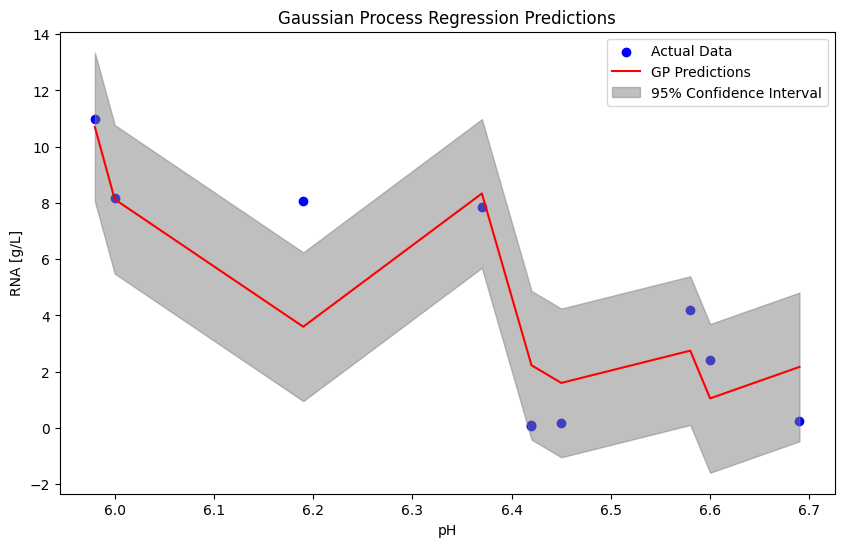

In [4]:
# plot the gaussian process model predictions
import matplotlib.pyplot as plt

y_test_pred, std = gp.predict(X_test, return_std=True)

# Sort by pH (X_test[:, 0]) for smoother confidence interval plotting
sorted_indices = np.argsort(X_test[:, 0])
X_test_sorted = X_test[sorted_indices]
y_test_sorted = y_test[sorted_indices]
y_test_pred_sorted = y_test_pred[sorted_indices]

# Use fixed noise level from kernel
noise_level = np.sqrt(gp.kernel_.k2.noise_level)
ci = 1.96 * noise_level

plt.figure(figsize=(10, 6))
plt.scatter(X_test_sorted[:, 0], y_test_sorted, color="blue", label="Actual Data")
plt.plot(X_test_sorted[:, 0], y_test_pred_sorted, color="red", label="GP Predictions")
plt.fill_between(
    X_test_sorted[:, 0],
    y_test_pred_sorted - ci,
    y_test_pred_sorted + ci,
    color="gray",
    alpha=0.5,
    label="95% Confidence Interval",
)
plt.xlabel(schema.IVTReactionSchema.pH.value)
plt.ylabel(schema.IVTReactionSchema.RNA_g_L.value)
plt.title("Gaussian Process Regression Predictions")
plt.legend()

Polynomial equation: -375.50x^5 + 11974.08x^4 + -152581.95x^3 + 971165.97x^2 + -3087517.54x^1 + 3922297.24x^0


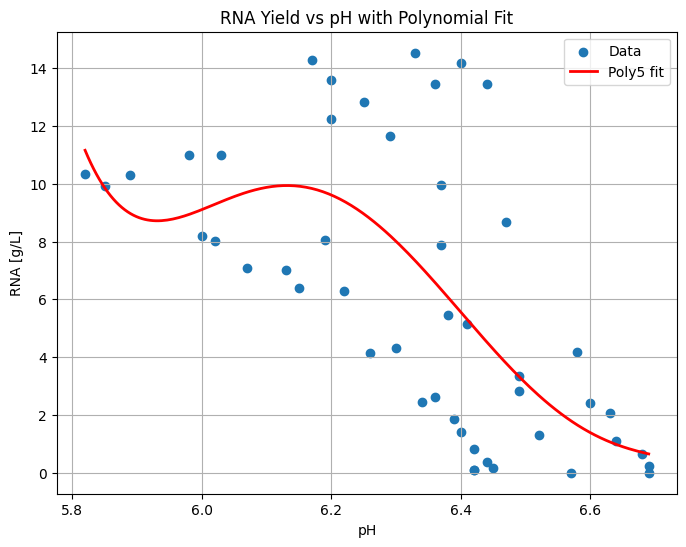

In [5]:
x = experimental_data[schema.IVTReactionSchema.pH.value].values
y = experimental_data[schema.IVTReactionSchema.RNA_g_L.value].values

# Fit a polynomial (degree can be changed, e.g., 2 or 3)
degree = 5
coeffs = np.polyfit(x, y, degree)
poly_func = np.poly1d(coeffs)

# Generate fitted curve
x_fit = np.linspace(x.min(), x.max(), 200)
y_fit = poly_func(x_fit)

# Print the polynomial equation
equation = " + ".join([f"{coeff:.2f}x^{degree-i}" for i, coeff in enumerate(coeffs)])
print(f"Polynomial equation: {equation}")

plt.figure(figsize=(8, 6))
plt.scatter(x, y, label="Data")
plt.plot(x_fit, y_fit, color="red", lw=2, label=f"Poly{degree} fit")
plt.xlabel("pH")
plt.ylabel("RNA [g/L]")
plt.title("RNA Yield vs pH with Polynomial Fit")
plt.legend()
plt.grid()

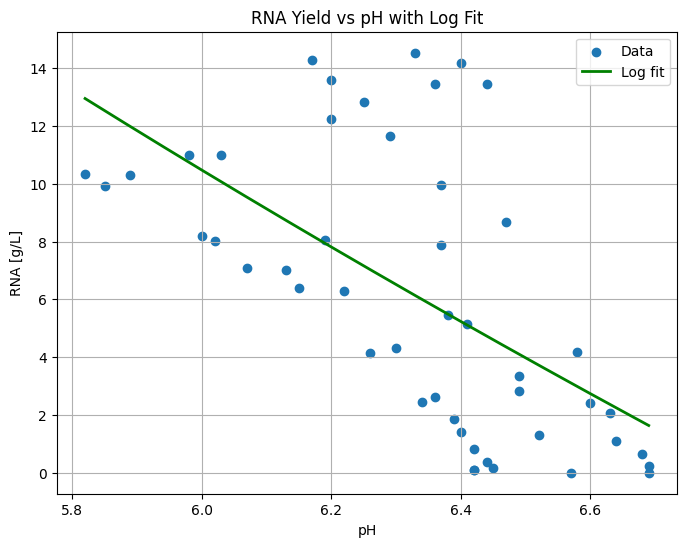

In [6]:
from scipy.optimize import curve_fit

x = experimental_data[schema.IVTReactionSchema.pH.value].values
y = experimental_data[schema.IVTReactionSchema.RNA_g_L.value].values


# Define a log function: y = a * log(x) + b
def log_func(x, a, b):
    return a * np.log(x) + b


# Fit the log function to the data
params, _ = curve_fit(log_func, x, y)
y_fit = log_func(np.linspace(x.min(), x.max(), 200), *params)

plt.figure(figsize=(8, 6))
plt.scatter(x, y, label="Data")
plt.plot(
    np.linspace(x.min(), x.max(), 200), y_fit, color="green", lw=2, label="Log fit"
)
plt.xlabel("pH")
plt.ylabel("RNA [g/L]")
plt.title("RNA Yield vs pH with Log Fit")
plt.legend()
plt.grid()
plt.show()

In [7]:
# build the gaussian process model with the log function as a feature

X_train, X_test, y_train, y_test = train_test_split(
    np.log(experimental_conditions[schema.IVTReactionSchema.pH.value].values).reshape(
        -1, 1
    ),
    response[y_columns[0]].values,
    test_size=0.2,
    random_state=42,
)

gp_log = GaussianProcessRegressor(
    kernel=C(1.0, (1e-2, 1e2)) * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
    + WhiteKernel(noise_level=1.0, noise_level_bounds=(1e-2, 1e2)),
    n_restarts_optimizer=50,
    random_state=42,
)
gp_log.fit(X_train, y_train)


# Evaluate the model with log feature
gp_log_metrics = evaluate_model(gp_log, X_train, y_train, X_test, y_test)
print(
    "Gaussian Process with Log Feature Metrics:", json.dumps(gp_log_metrics, indent=4)
)

Gaussian Process with Log Feature Metrics: {
    "r2": {
        "train": 0.36954453643906593,
        "test": 0.38522685925260813
    },
    "mae": {
        "train": 3.1843720777189093,
        "test": 2.345639119080991
    },
    "rmse": {
        "train": 3.842122048777742,
        "test": 3.1268429294880153
    }
}


In [8]:
# Look at the length scale of the kernel
# Look at the length scale of the kernel
length_scale = gp_log.kernel_.k1.k2.length_scale
print("RBF length scale:", length_scale)

RBF length scale: 0.08844217005411105


Gaussian Process with Polynomial Feature Metrics: {
    "r2": {
        "train": 0.38185003088425484,
        "test": 0.38332948418937707
    },
    "mae": {
        "train": 3.115619872578849,
        "test": 2.383114372426293
    },
    "rmse": {
        "train": 3.804441199388053,
        "test": 3.131664401720079
    }
}
RBF length scale with Polynomial Feature: 23.139354119565454


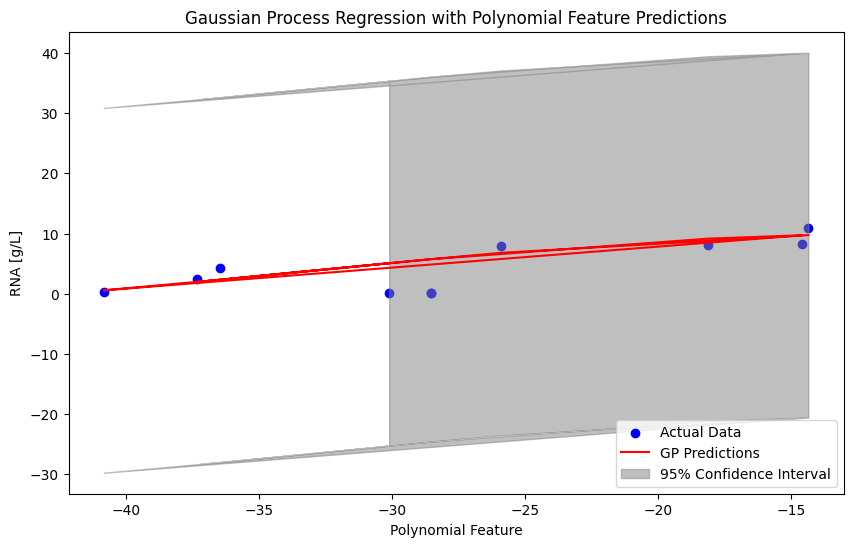

In [9]:
# Fit the model using the polynomial features
# Polynomial equation: -375.50x^5 + 11974.08x^4 + -152581.95x^3 + 971165.97x^2 + -3087517.54x^1 + 3922297.24x^0

pH = experimental_data[schema.IVTReactionSchema.pH.value].values
poly_feature = (
    -375.50 * pH**5
    + 11974.08 * pH**4
    - 152581.95 * pH**3
    + 971165.97 * pH**2
    - 3087517.54 * pH
    + 3922297.24
)

# Fit the model with the polynomial feature
X = poly_feature.reshape(-1, 1)
y = response[y_columns[0]].values

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
)
gp_poly = GaussianProcessRegressor(
    kernel=C(1.0, (1e-2, 1e2)) * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
    + WhiteKernel(noise_level=1.0, noise_level_bounds=(1e-2, 1e2)),
    n_restarts_optimizer=50,
    random_state=42,
)
gp_poly.fit(X_train, y_train)


# Evaluate the model with polynomial feature
gp_poly_metrics = evaluate_model(gp_poly, X_train, y_train, X_test, y_test)
print(
    "Gaussian Process with Polynomial Feature Metrics:",
    json.dumps(gp_poly_metrics, indent=4),
)
# Look at the length scale of the kernel
length_scale_poly = gp_poly.kernel_.k1.k2.length_scale
print("RBF length scale with Polynomial Feature:", length_scale_poly)

# Show the Gaussian Process model predictions with kernel noise levels
y_test_pred_poly = gp_poly.predict(X_test)
plt.figure(figsize=(10, 6))
plt.scatter(X_test, y_test, color="blue", label="Actual Data")
plt.plot(X_test, y_test_pred_poly, color="red", label="GP Predictions")
plt.fill_between(
    X_test.flatten(),
    y_test_pred_poly - 1.96 * gp_poly.kernel_.k2.noise_level,
    y_test_pred_poly + 1.96 * gp_poly.kernel_.k2.noise_level,
    color="gray",
    alpha=0.5,
    label="95% Confidence Interval",
)
plt.xlabel("Polynomial Feature")
plt.ylabel(schema.IVTReactionSchema.RNA_g_L.value)
plt.title("Gaussian Process Regression with Polynomial Feature Predictions")
plt.legend()

Linear Regression Metrics: {
    "r2": {
        "train": 0.3586260164718722,
        "test": 0.43395434574797265
    },
    "mae": {
        "train": 3.2325581017459406,
        "test": 2.313269524957247
    },
    "rmse": {
        "train": 3.8752490625309304,
        "test": 3.0003668166903648
    }
}


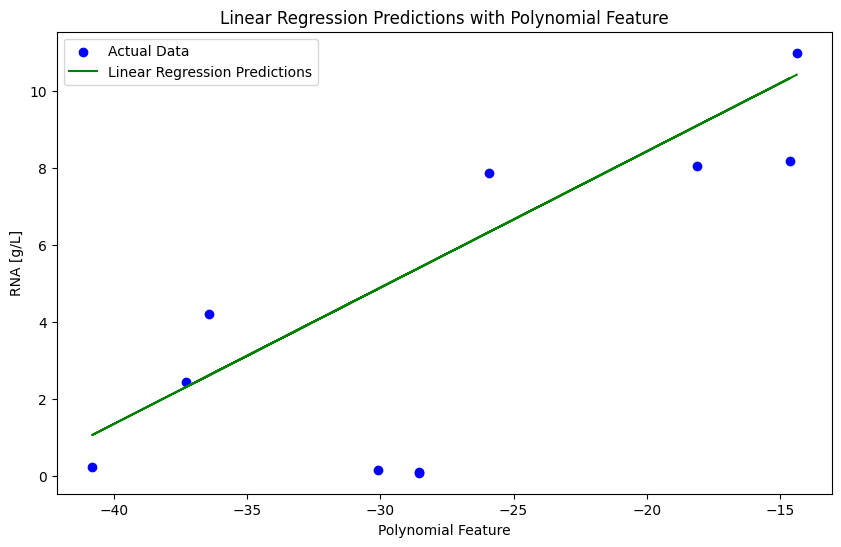

In [10]:
# Fit a linear regression model with the polynomial feature

from sklearn.linear_model import LinearRegression

linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
# Evaluate the linear regression model
linear_metrics = evaluate_model(linear_model, X_train, y_train, X_test, y_test)
print("Linear Regression Metrics:", json.dumps(linear_metrics, indent=4))

# Plot the linear regression model predictions
y_test_pred_linear = linear_model.predict(X_test)
plt.figure(figsize=(10, 6))
plt.scatter(X_test, y_test, color="blue", label="Actual Data")
plt.plot(
    X_test, y_test_pred_linear, color="green", label="Linear Regression Predictions"
)
plt.xlabel("Polynomial Feature")
plt.ylabel(schema.IVTReactionSchema.RNA_g_L.value)
plt.title("Linear Regression Predictions with Polynomial Feature")
plt.legend()

Gaussian Process with Scaled Data Metrics: {
    "r2": {
        "train": 0.569468736486497,
        "test": 0.512570802454481
    },
    "mae": {
        "train": 0.18431398616634118,
        "test": 0.160626822263492
    },
    "rmse": {
        "train": 0.2184168831812553,
        "test": 0.1915333046581173
    }
}
RBF length scale with Scaled Data: 37.43978926163587


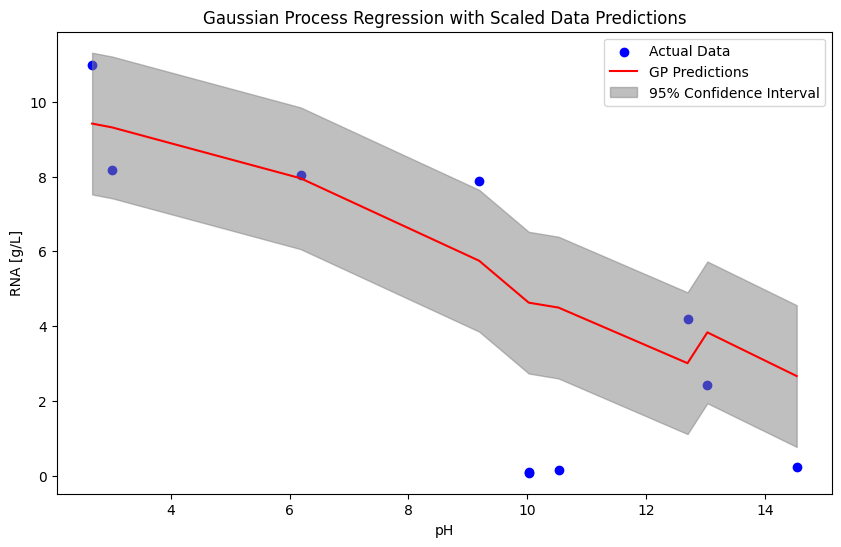

In [13]:
# Autoscale the x and y axes and train the model again

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(experimental_conditions.values)
y_scaled = scaler.fit_transform(response.values.reshape(-1, 1)).flatten()

# Train and test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled,
    y_scaled,
    test_size=0.2,
    random_state=42,
)

# Fit the Gaussian Process model with scaled data
gp_scaled = GaussianProcessRegressor(
    kernel=C(1.0, (1e-2, 1e2))
    * Matern(length_scale=1.0, length_scale_bounds=(1e-2, 1e2), nu=0.2)
    + WhiteKernel(noise_level=1.0, noise_level_bounds=(1e-2, 1e2)),
    n_restarts_optimizer=50,
    random_state=42,
)
gp_scaled.fit(X_train, y_train)
# Evaluate the scaled model
gp_scaled_metrics = evaluate_model(gp_scaled, X_train, y_train, X_test, y_test)
print(
    "Gaussian Process with Scaled Data Metrics:",
    json.dumps(gp_scaled_metrics, indent=4),
)

# show length scale of the kernel
length_scale_scaled = gp_scaled.kernel_.k1.k2.length_scale
print("RBF length scale with Scaled Data:", length_scale_scaled)

# Plot the scaled Gaussian Process model predictions in normal space
# Sort the test data by the first feature (pH) for smooth plotting
sort_idx = np.argsort(scaler.inverse_transform(X_test)[:, 0])
X_test_sorted = X_test[sort_idx]
y_test_sorted = y_test[sort_idx]

# Predict on the test set
y_test_pred_scaled = gp_scaled.predict(X_test)
y_test_pred_scaled_sorted = y_test_pred_scaled[sort_idx]

# Get the noise level from the kernel
noise_level = gp_scaled.kernel_.k2.noise_level

# Inverse transform for plotting
x_plot = scaler.inverse_transform(X_test_sorted)[:, 0]
y_plot = scaler.inverse_transform(y_test_sorted.reshape(-1, 1)).flatten()
y_pred_plot = scaler.inverse_transform(
    y_test_pred_scaled_sorted.reshape(-1, 1)
).flatten()

ci = 1.96 * noise_level
lower_bound = scaler.inverse_transform(
    (y_test_pred_scaled_sorted - ci).reshape(-1, 1)
).flatten()
upper_bound = scaler.inverse_transform(
    (y_test_pred_scaled_sorted + ci).reshape(-1, 1)
).flatten()

plt.figure(figsize=(10, 6))
plt.scatter(x_plot, y_plot, color="blue", label="Actual Data")
plt.plot(x_plot, y_pred_plot, color="red", label="GP Predictions")
plt.fill_between(
    x_plot,
    lower_bound,
    upper_bound,
    color="gray",
    alpha=0.5,
    label="95% Confidence Interval",
)
plt.xlabel(schema.IVTReactionSchema.pH.value)
plt.ylabel(schema.IVTReactionSchema.RNA_g_L.value)
plt.title("Gaussian Process Regression with Scaled Data Predictions")
plt.legend()

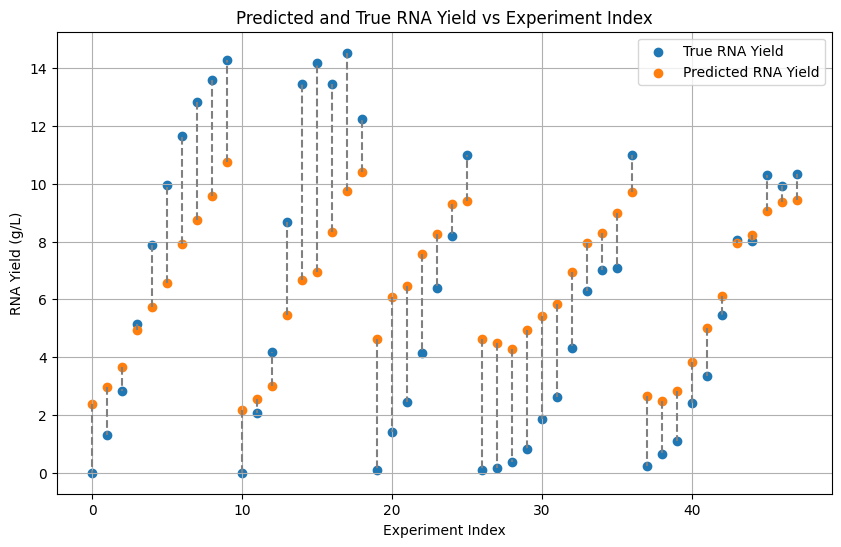

In [14]:
import pandas as pd

# Use separate scalers for X and y
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(experimental_conditions.values)
y_scaled = scaler_y.fit_transform(response.values.reshape(-1, 1)).flatten()

# When predicting for the full dataset:
X_full_scaled = scaler_X.transform(experimental_conditions.values)
y_full_pred_scaled = gp_scaled.predict(X_full_scaled)
y_full_pred = scaler_y.inverse_transform(y_full_pred_scaled.reshape(-1, 1)).flatten()

# 4. Prepare a DataFrame for plotting (to match your plotting code style)
predictions_df = pd.DataFrame({schema.IVTReactionSchema.RNA_g_L.value: y_full_pred})

# 5. Plot in the requested format
experimental_condition_index = np.arange(len(experimental_conditions))

plt.figure(figsize=(10, 6))
plt.scatter(
    experimental_condition_index,
    response[schema.IVTReactionSchema.RNA_g_L.value],
    marker="o",
    label="True RNA Yield",
)

ax = plt.gca()
for i in experimental_condition_index:
    ax.vlines(
        i,
        predictions_df[schema.IVTReactionSchema.RNA_g_L.value].iloc[i],
        response[schema.IVTReactionSchema.RNA_g_L.value].iloc[i],
        color="gray",
        linestyle="--",
    )
plt.scatter(
    experimental_condition_index,
    predictions_df[schema.IVTReactionSchema.RNA_g_L.value],
    marker="o",
    label="Predicted RNA Yield",
)

plt.xlabel("Experiment Index")
plt.ylabel("RNA Yield (g/L)")
plt.title("Predicted and True RNA Yield vs Experiment Index")
plt.legend()
plt.grid()
plt.show()